<a href="https://colab.research.google.com/github/jpedro-rod/ElementosFinitos/blob/main/Elementos_Finitos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import itertools as it   #biblioteca com funções de permutação a serem usadas na interação da matriz de conectividade com a global

Formulação forte de um problema de condução de calor estacionário em uma placa:

$\nabla\cdot\vec{q} + G = 0 \;,\;\; \vec{q} = -k\nabla T$

Formulação fraca:

$∫_{\Omega}[\nabla\cdot\vec{q} + G]\cdot \omega(x,y) \;\; d\Omega = 0, ∀\omega \in U^0$

$∫_{\Omega}[\nabla\cdot\vec{q}\omega + G\omega] \;\; d\Omega = 0, ∀\omega \in U^0$

Pelo Teorema de Green (que assume a forma de integral por partes em 01 dimensão):

$\oint_{\Gamma}\omega\vec{q}\cdot\vec{n} \; d\Gamma - \int_{Ω} \nabla\omega\cdot\vec{q} \;\; dΩ + \int_{\Omega} G\omega \;\; dΩ= 0 \;\;\;\; (I)$

Reescrevendo a 1ª parcela em função das condições de contorno, ter-se-á:

$\oint_{\Gamma}\omega\vec{q}\cdot\vec{n} \; d\Gamma = \int_{\Gamma_q} \omega\vec{q}\cdot\vec{n} \; d\Gamma_q + \int_{\Gamma_T} \omega\vec{q}\cdot\vec{n} \; d\Gamma_T$

Sabe-se ainda que $\omega(x,y)=0$ em $\Gamma_T$ (para C.C. de Dirichlet), o que simplifica a equação oriunda do Teorema de Green:

$\oint_{\Gamma}\omega\vec{q}\cdot\vec{n} \; d\Gamma = \int_{\Gamma_q} \omega\vec{q}\cdot\vec{n} \; d\Gamma_q \;\;\;\; (II)$

Inserindo $II$ em $I$ e definindo $\overline{q}=\vec{q}\cdot\vec{n}$ finalmente:

$$ \int_{Ω} \nabla\omega\cdot(-k\nabla T) \;\; dΩ = \int_{\Gamma_q} \omega\overline{q} \;\; dΓ_q + \int_{\Omega} \omega G \;\; dΩ $$

Discretizando a fórmula fraca:

$$ T(x) = \sum_{i}^{\infty} N_i \cdot T_i \:,\;\; \omega(x) = \sum_{j}^{\infty} N_j \cdot w_j $$

$$ \int_{Ω} \sum_{i}^{\infty} \sum_{j}^{\infty} -B_j \omega_j \cdot k \cdot B_i T_i \;\; dΩ = \int_{\Gamma_q} \sum_{j}^{\infty} N_j \omega_j \cdot \overline{q} \;\; dΓ_q + \int_{\Omega} \sum_{j}^{\infty} N_j \omega_j \cdot G \;\; dΩ \:,\;\; B_n = \nabla N_n  $$

$N$ é o vetor de funções de interpolação (ou de forma). Índices diferentes representam vetores transpostos.

$$ \sum_{i}^{\infty} \sum_{j}^{\infty} \int_{Ω} -B_j k B_i \cdot T_i \;\; dΩ = \sum_{j}^{\infty} \int_{\Gamma_q} N_j \cdot \overline{q} \;\; dΓ_q + \sum_{j}^{\infty} \int_{\Omega} N_j \cdot G \;\; dΩ $$

## Funções de forma (ou de interpolação)

In [3]:
#1ª ordem:
#N1 = [N11, N12]

def N11(x,X1,X2):
    return (X2-x)/(X2-X1)

def N12(x,X1,X2):
    return (x-X1)/(X2-X1)

def B11(x,X1,X2):
    return -1/(X2-X1)

def B12(x,X1,X2):
    return 1/(X2-X1)

#2ª ordem:
#N2 = [N21, N22, N23]

def N21(x,X1,X2,X3):
    return 2*(x-X2)*(x-X3)/(X3-X1)**2

def N22(x,X1,X2,X3):
    return (-4)*(x-X1)*(x-X3)/(X3-X1)**2

def N23(x,X1,X2,X3):
    return 2*(x-X1)*(x-X2)/(X3-X1)**2

# B2 = [B21, B22, B23]

def B21(x,X1,X2,X3):
    return 2*(2*x-(X2+X3))/(X3-X1)**2

def B22(x,X1,X2,X3):
    return (-4)*(2*x-(X1+X3))/(X3-X1)**2

def B23(x,X1,X2,X3):
    return 2*(2*x-(X1+X2))/(X3-X1)**2

## Condução de calor em barra delgada em regime permanente

Condução de calor numa barra fina e homogênea com extremidades a temperaturas fixas e submetida a geração de calor de comportamento linear:

$L = 4\:m = 4 \;,\;\; A = 1\:m^2 \;,\;\; K = 5\:W/(°Cm)$

$G(x) = \frac{50}{3}(x+2) \;,\;\; T(x=1) = 100°C \;,\;\; T(x=4) = 0$

$$ \sum_i^{\infty} \sum_j^{\infty} \int_{Ω} B_j k B_i \;\; dx \cdot T_i + \sum_j^{\infty} \int_{\Omega} N_j \cdot G \;\; dx = 0 $$

$$ K = \int_{x_o}^{x_f} B_j k B_i \;\; dx \:,\;\; B = \int_{x_o}^{x_f} N_j \;\; dx $$


### Integrando para obter matriz de rigidez e vetor de termos indepedentes

Matriz de conectividade: 
[[ 0.  1.  2.]
 [ 2.  3.  4.]
 [ 4.  5.  6.]
 [ 6.  7.  8.]
 [ 8.  9. 10.]]

Matrizes globais: 
K
[[ 44.44 -22.22   0.     0.     0.     0.     0.     0.     0.  ]
 [-22.22  38.89 -22.22   2.78   0.     0.     0.     0.     0.  ]
 [  0.   -22.22  44.44 -22.22   0.     0.     0.     0.     0.  ]
 [  0.     2.78 -22.22  38.89 -22.22   2.78   0.     0.     0.  ]
 [  0.     0.     0.   -22.22  44.44 -22.22   0.     0.     0.  ]
 [  0.     0.     0.     2.78 -22.22  38.89 -22.22   2.78   0.  ]
 [  0.     0.     0.     0.     0.   -22.22  44.44 -22.22   0.  ]
 [  0.     0.     0.     0.     0.     2.78 -22.22  38.89 -22.22]
 [  0.     0.     0.     0.     0.     0.     0.   -22.22  44.44]]
G
[-2200.22   289.78    26.      14.      30.      16.      34.      18.
    38.  ]

Nós (solução numérica): 
[100.    84.46  69.92  56.45  44.16  33.12  23.44  15.19   8.48   3.38
   0.  ]


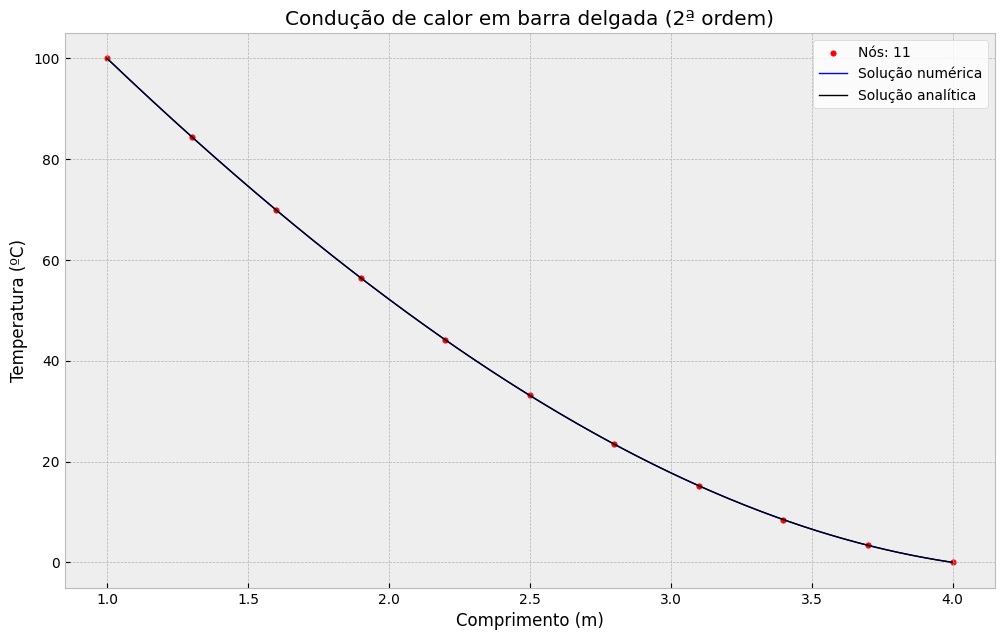

In [3]:
#Parâmetros Físicos

Xo = 1
Xf = 4
A = 1
k = 5
To = 100
Tf = 0

def S(x):
    return (50/3)*(x+2)

#Parâmetros numéricos############################

#OBS.: "ligacoes" se difere de nós pois se refere a pontos que ficam apenas nas fronteiras de cada elemento. "ligacoes" não abrange nós no interior de elementos, como nos de 2ª ordem.

ordemElemento = 2   #1 ou 2

ligacoes = 6                              
malha = np.linspace(Xo,Xf,ligacoes)

#################################################

##Produtos das funções de forma 1ª ordem
if ordemElemento == 1:

    ###Definindo nº de elementos e nós 
    nElementos = len(malha)-1
    nNos = nElementos+1
    
    nNosLocais = 2

    K11 = lambda x,X1,X2 : B11(x,X1,X2)*k*B11(x,X1,X2)
    K12 = lambda x,X1,X2 : B11(x,X1,X2)*k*B12(x,X1,X2)
    K21 = lambda x,X1,X2 : B12(x,X1,X2)*k*B11(x,X1,X2)
    K22 = lambda x,X1,X2 : B12(x,X1,X2)*k*B12(x,X1,X2)

    G1 = lambda x,X1,X2 : S(x)*N11(x,X1,X2)
    G2 = lambda x,X1,X2 : S(x)*N12(x,X1,X2)

    ###Função de integração a ser usada
    def INTEGRACAO_1(f,X1,X2):
        return sp.integrate.quad(f,X1,X2,(X1,X2))[0]

##Integrando e montando
    listaKe = np.empty((2,2,nElementos))
    listaGe = np.empty((1,2,nElementos))

    for e in range(0,nElementos):
        Ke = np.array([[INTEGRACAO_1(K11,malha[e],malha[e+1]),INTEGRACAO_1(K12,malha[e],malha[e+1])],
                    [INTEGRACAO_1(K21,malha[e],malha[e+1]),INTEGRACAO_1(K22,malha[e],malha[e+1])]])         

        Ge = np.array([[INTEGRACAO_1(G1,malha[e],malha[e+1]),INTEGRACAO_1(G2,malha[e],malha[e+1])]])

        listaKe[:,:,e] = Ke
        listaGe[:,:,e] = Ge


##Produtos das funções de forma 2ª ordem
elif ordemElemento == 2:
    
    ###Definindo nº de elementos e nós
    nElementos = int(len(malha)-1)
    nNos = nElementos + 1 + nElementos
    nNosLocais = 3

    ###MalhaPLT (Malha para plotagem (com os pontos intermediários de cada elemento))
    malhaPlot_e0 = np.array([malha[0],(malha[0]+malha[1])/2,malha[1]])   #1º elemento
    
    malhaPlot = np.empty(nNos-3)  #demais elementos

    for i in range(1,nElementos):

        nosElemento = np.array([(malha[i]+malha[i+1])/2, malha[i+1]])  
        malhaPlot[2*(i-1):2*(i)] = nosElemento

    malhaPLT = np.concatenate((malhaPlot_e0,malhaPlot))

    K11 = lambda x,X1,X2,X3 : B21(x,X1,X2,X3)*k*B21(x,X1,X2,X3)
    K12 = lambda x,X1,X2,X3 : B21(x,X1,X2,X3)*k*B22(x,X1,X2,X3)
    K13 = lambda x,X1,X2,X3 : B21(x,X1,X2,X3)*k*B23(x,X1,X2,X3)
    K21 = lambda x,X1,X2,X3 : B22(x,X1,X2,X3)*k*B21(x,X1,X2,X3)
    K22 = lambda x,X1,X2,X3 : B22(x,X1,X2,X3)*k*B22(x,X1,X2,X3)
    K23 = lambda x,X1,X2,X3 : B22(x,X1,X2,X3)*k*B23(x,X1,X2,X3)
    K31 = lambda x,X1,X2,X3 : B23(x,X1,X2,X3)*k*B21(x,X1,X2,X3)
    K32 = lambda x,X1,X2,X3 : B23(x,X1,X2,X3)*k*B22(x,X1,X2,X3)
    K33 = lambda x,X1,X2,X3 : B23(x,X1,X2,X3)*k*B23(x,X1,X2,X3)

    G1 = lambda x,X1,X2,X3 : S(x)*N21(x,X1,X2,X3)
    G2 = lambda x,X1,X2,X3 : S(x)*N22(x,X1,X2,X3)
    G3 = lambda x,X1,X2,X3 : S(x)*N23(x,X1,X2,X3)

    ###Função de integração a ser usada
    def INTEGRACAO_2(f,X1,X2,X3):
        return sp.integrate.quad(f,X1,X3,(X1,X2,X3))[0]

##Integrando e montando
    listaKe = np.empty((3,3,nElementos))
    listaGe = np.empty((1,3,nElementos))

    '''Há um if dentro do loop porque elementos de 2ª ordem podem terminar incompletos dependendo de como discretizarmos o domínio. Dessa forma é 
    necessário definir uma integração particular para o último elemento em que o integramos só até a metade'''
    
    indice_elemento = 0
    for e in range(0,nElementos):

        no_medio = (malha[e]+malha[e+1])/2
        Ke = np.array([[INTEGRACAO_2(K11,malha[e],no_medio,malha[e+1]),INTEGRACAO_2(K12,malha[e],no_medio,malha[e+1]),INTEGRACAO_2(K13,malha[e],no_medio,malha[e+1])],
                    [INTEGRACAO_2(K21,malha[e],no_medio,malha[e+1]),INTEGRACAO_2(K22,malha[e],no_medio,malha[e+1]),INTEGRACAO_2(K23,malha[e],no_medio,malha[e+1])],
                    [INTEGRACAO_2(K31,malha[e],no_medio,malha[e+1]),INTEGRACAO_2(K32,malha[e],no_medio,malha[e+1]),INTEGRACAO_2(K33,malha[e],no_medio,malha[e+1])]])
            
        Ge = np.array([[INTEGRACAO_2(G1,malha[e],no_medio,malha[e+1]),INTEGRACAO_2(G2,malha[e],no_medio,malha[e+1]),INTEGRACAO_2(G3,malha[e],no_medio,malha[e+1])]])

        listaKe[:,:,indice_elemento] = Ke
        listaGe[:,:,indice_elemento] = Ge
        indice_elemento = indice_elemento + 1

# Matriz de conectividade (IEN)

IEN = np.zeros((nElementos,nNosLocais))

##1ª ORDEM
if ordemElemento == 1:
        
    for elemento in range(nElementos):
        for noLocal in range(nNosLocais):
                
            IEN[elemento,noLocal] = elemento*(nNosLocais - 1) + noLocal

##2ª ORDEM
elif ordemElemento == 2:
    for elemento in range(nElementos):

        for noLocal in range(nNosLocais):

            IEN[elemento,noLocal] = elemento*(nNosLocais - 1) + noLocal

print("Matriz de conectividade: ")
print(IEN)

#Matrizes globais

Ks = np.zeros((nNos,nNos))    #Ks pois se refere a matriz global ainda em seu estado singular
Gs= np.zeros(nNos)

nMatrizesElementares = len(listaKe[0,0,:])

##1ª ORDEM
if ordemElemento == 1:

    ###Adicionando cada matriz elementar à matriz global
    for K_elementar_index in range(nMatrizesElementares):

        Kaux = np.zeros((nNos,nNos))

        ##Permutação da matriz global
        posicoes = list(it.product(IEN[K_elementar_index], repeat=2))   #Retorna tuplas de permutações da lista. O parâmetro r define quantos elementos da lista permutar por vez
        posicoes = [(int(x), int(y)) for x,y in posicoes]             #O método retorna tuplas de floats, apenas passei os dados para int
                
        ##Permutação da matriz elementar
        posicoes_locais = list(it.product([0,1], repeat=2))   #Retorna tuplas de permutações da lista. O parâmetro r define quantos elementos da lista permutar por vez
        posicoes_locais = [(int(x), int(y)) for x,y in posicoes_locais]
                
        #print(posicoes)
        #print(posicoes_locais)
        for i in range(len(posicoes)):
            posicao_global = posicoes[i] 
            posicao_local = posicoes_locais[i] + (K_elementar_index,)
            Kaux[posicao_global] = listaKe[posicao_local]
        #print(Kaux)
        Ks = Ks + Kaux
        
    ###Adicionando cada matriz elementar Ge à matriz global G
    for G_elementar_index in range(nMatrizesElementares):
        
        Gaux = np.zeros(nNos)

        for i in range(2):
            Gaux[G_elementar_index*(nNosLocais - 1) + i] = listaGe[:,i,G_elementar_index]
        #print(Gaux)
        Gs = Gs + Gaux
        
    #print("\nMatrizes globais singulares: ")
    #print("Ks")  
    #print(np.array_str(Ks, precision=2, suppress_small=True))
    #print("Gs")
    #print(np.array_str(Gs, precision=2, suppress_small=True))
    
##2ª ORDEM
elif ordemElemento == 2:

    ###Adicionando cada matriz elementar Ke à matriz global K
    for K_elementar_index in range(nMatrizesElementares):
        
        Kaux = np.zeros((nNos,nNos))

        ##Permutação da matriz global
        posicoes = list(it.product(IEN[K_elementar_index], repeat=2))   #Retorna tuplas de permutações da lista. O parâmetro r define quantos elementos da lista permutar por vez
        posicoes = [(int(x), int(y)) for x,y in posicoes]             #O método retorna tuplas de floats, apenas passei os dados para int
        
        ##Permutação da matriz elementar
        posicoes_locais = list(it.product([0,1,2], repeat=2))   #Retorna tuplas de permutações da lista. O parâmetro r define quantos elementos da lista permutar por vez
        posicoes_locais = [(int(x), int(y)) for x,y in posicoes_locais]
        
        #print(posicoes)
        #print(posicoes_locais)
        for i in range(len(posicoes)):
            posicao_global = posicoes[i]
            posicao_local = posicoes_locais[i] + (K_elementar_index,)
            Kaux[posicao_global] = listaKe[posicao_local]
        #print(Kaux)
        Ks = Ks + Kaux
        
    ###Adicionando cada matriz elementar Ge à matriz global G
    for G_elementar_index in range(nMatrizesElementares):
        
        Gaux = np.zeros(nNos)

        for i in range(3):
            Gaux[G_elementar_index*(nNosLocais - 1) + i] = listaGe[:,i,G_elementar_index]

        Gs = Gs + Gaux
    
    #print("\nMatrizes globais singulares: ")
    #print("Ks")  
    #print(np.array_str(Ks, precision=2, suppress_small=True))
    #print("Gs")
    #print(np.array_str(Gs, precision=2, suppress_small=True))
    
#Aplicação das condições de contorno na matriz e vetor independente:   K.T + G = 0

##K
###1º contorno
K = np.delete(Ks,obj=0,axis=0)   #eliminando linha
K = np.delete(K,obj=0, axis=1)   #eliminando coluna
###2º contorno
K = np.delete(K,obj=-1, axis=0)    #eliminando linha
K = np.delete(K,obj=-1, axis=1)   #eliminando coluna

##G
G = Gs[1:-1]
KLinhaEliminada = np.delete(Ks,obj=0,axis=0)
KLinhaEliminada = np.delete(KLinhaEliminada,obj=-1,axis=0)

for i in range(len(G)):

    G[i] = G[i] + To*KLinhaEliminada[i,0] + Tf*KLinhaEliminada[i,-1]

print("\nMatrizes globais: ")
print("K")  
print(np.array_str(K, precision=2, suppress_small=True))
print("G")
print(np.array_str(G, precision=2, suppress_small=True))

#Solucionando o sistema##########################

CampoTSemContorno = np.linalg.solve(K,-G)

BCo = np.array([To])
BCf = np.array([Tf])
Tnos = np.concatenate((BCo,CampoTSemContorno,BCf))

print("\nNós (solução numérica): ")
print(np.array_str(Tnos, precision=2, suppress_small=True))

#Gerando o campo de temperatura##################

def CampoTNumerico(malha,T):
    
    if ordemElemento == 1:
        np_e = 10   #nº de pontos que a interpolação calculará no interior de cada elemento

        #Separamos o 1º elemento do restante do loop pq cada elemento compartilha seu nó inicial com o fim do elemento anterior
        #Por isso inserimos um 1º elemento por completo e depois vamos completando os nós dos demais

        ##1º elemento
        Dom_interpol_e0 = np.linspace(malha[0],malha[1],np_e)
        interpol_e0 = np.array(N11(Dom_interpol_e0,malha[0],malha[0+1])*T[0] + N12(Dom_interpol_e0,malha[0],malha[0+1])*T[0+1])
        
        ##demais elementos
        Dom_interpol = np.empty((nElementos-1)*(np_e-1))
        interpol = np.empty((nElementos-1)*(np_e-1))
        
        for i in range(1, nElementos):

            Dom_interpol_e = np.linspace(malha[i], malha[i+1], np_e)
            npDom = len(Dom_interpol_e)
            
            S = N11(Dom_interpol_e,malha[i],malha[i+1])*T[i] + N12(Dom_interpol_e,malha[i],malha[i+1])*T[i+1]
             
            Dom_interpol[(npDom-1)*(i-1) : (npDom-1)*(i)] = Dom_interpol_e[1:]
            interpol[(npDom-1)*(i-1) : (npDom-1)*(i)] = S[1:]
        
        Dom_interpol = np.concatenate((Dom_interpol_e0, Dom_interpol))
        Campo_T = np.concatenate((interpol_e0, interpol))

        return Dom_interpol, Campo_T
    
    elif ordemElemento == 2:
        np_e = 10   #nº de pontos que a interpolação calculará no interior de cada elemento

        #Separamos o 1º elemento do restante do loop pq cada elemento compartilha seu nó inicial com o fim do elemento anterior
        #Por isso inserimos um 1º elemento por completo e depois vamos completando os nós dos demais

        ##1º elemento
        no_medio_e0 = (malha[0]+malha[1])/2
        Dom_interpol_e0 = np.linspace(malha[0],malha[1],np_e)
        interpol_e0 = np.array(N21(Dom_interpol_e0,malha[0],no_medio_e0,malha[1])*T[0] 
                             + N22(Dom_interpol_e0,malha[0],no_medio_e0,malha[1])*T[0+1] 
                             + N23(Dom_interpol_e0,malha[0],no_medio_e0,malha[1])*T[0+2])
        
        ##demais elementos
        Dom_interpol = np.empty((nElementos-1)*(np_e-1))
        interpol = np.empty((nElementos-1)*(np_e-1))

        for i in range(1,nElementos):

            no_medio = (malha[i]+malha[i+1])/2
            
            Dom_interpol_e = np.linspace(malha[i],malha[i+1],np_e)
            npDom = len(Dom_interpol_e)
            
            S = np.array(N21(Dom_interpol_e,malha[i],no_medio,malha[i+1])*T[2*i] 
                       + N22(Dom_interpol_e,malha[i],no_medio,malha[i+1])*T[2*i+1] 
                       + N23(Dom_interpol_e,malha[i],no_medio,malha[i+1])*T[2*i+2])

            Dom_interpol[(npDom-1)*(i-1) : (npDom-1)*i] = Dom_interpol_e[1:]
            interpol[(npDom-1)*(i-1) : (npDom-1)*i] = S[1:]

        Dom_interpol = np.concatenate((Dom_interpol_e0, Dom_interpol))
        Campo_T = np.concatenate((interpol_e0, interpol))

        return Dom_interpol, Campo_T

#Solução analítica

Dom_analitica = np.linspace(Xo,Xf,500)

def CampoTAnalitico(x):
    return (5/9)*x**3 + (10/3)*x**2 - (185/3)*x + 1420/9

#Exibindo as soluções

plt.style.use('bmh')

fig, (ax1) = plt.subplots(1, 1, sharey=True, sharex = True, figsize = (12,7.2))

if ordemElemento == 1:

    ax1.scatter(malha, Tnos, s=15, color='red', label=r'Nós: {}'.format(nNos))
    ax1.plot(CampoTNumerico(malha,Tnos)[0], CampoTNumerico(malha,Tnos)[1], color='blue', linewidth=1.0, label=r'Solução numérica')
    #ax1.scatter(CampoTNumerico(malha,Tnos)[0], CampoTNumerico(malha,Tnos)[1], color='blue', s=15, label=r'Solução numérica')
    ax1.plot(Dom(240), CampoTAnalitico(Dom(240)), color='black', linewidth=1.0, label=r'Solução analítica')
    ax1.set_title('Condução de calor em barra delgada (1ª ordem)')
    ax1.set_xlabel('Comprimento (m)')
    ax1.set_ylabel('Temperatura (ºC)')
    ax1.legend(loc='best',facecolor ='w')


elif ordemElemento == 2:

    ax1.scatter(malhaPLT, Tnos, s=15, color='red', label=r'Nós: {}'.format(nNos))
    ax1.plot(CampoTNumerico(malha,Tnos)[0], CampoTNumerico(malha,Tnos)[1], color='blue', linewidth=1.0, label=r'Solução numérica')
    #ax1.scatter(CampoTNumerico(malha,Tnos)[0], CampoTNumerico(malha,Tnos)[1], color='blue', s=15, label=r'Solução numérica')
    ax1.plot(Dom_analitica, CampoTAnalitico(Dom_analitica), color='black', linewidth=1.0, label=r'Solução analítica')
    ax1.set_title('Condução de calor em barra delgada (2ª ordem)')
    ax1.set_xlabel('Comprimento (m)')
    ax1.set_ylabel('Temperatura (ºC)')
    ax1.legend(loc='best',facecolor ='w')

### Usando matrizes prontas (para elementos de 1ª e 2ª ordem em malhas uniformes e estruturadas)

Matriz de conectividade: 
[[0. 1.]
 [1. 2.]
 [2. 3.]
 [3. 4.]
 [4. 5.]]

Matrizes globais: 
K
[[16.67 -8.33  0.    0.  ]
 [-8.33 16.67 -8.33  0.  ]
 [ 0.   -8.33 16.67 -8.33]
 [ 0.    0.   -8.33 16.67]]
G
[-797.33   42.     48.     54.  ]

Nós (solução numérica): 
[100.    69.92  44.16  23.44   8.48   0.  ]


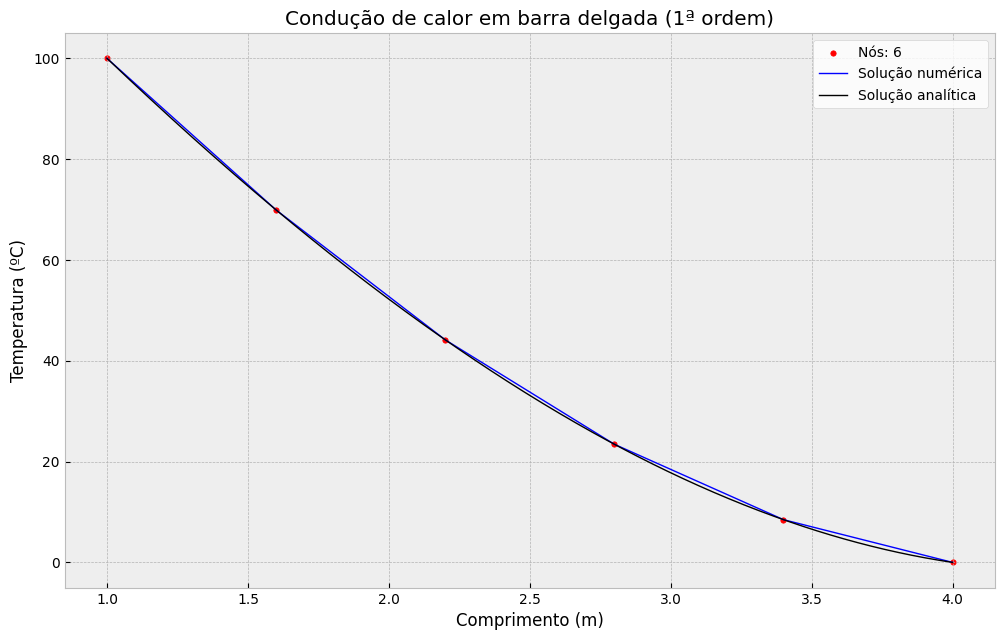

In [4]:
#Parâmetros Físicos#############################

Xo = 1
Xf = 4
A = 1
k = 5
To = 100
Tf = 0

def S(x):
    return (50/3)*(x+2)

#Parâmetros numéricos############################

#OBS.: "ligacoes" se difere de nós pois se refere a pontos que ficam apenas nas fronteiras de cada elemento. "ligacoes" não abrange nós no interior de elementos, como nos de 2ª ordem.

ordemElemento = 1   #1 ou 2

ligacoes = 6        
malha = np.linspace(Xo,Xf,ligacoes)

#################################################

##Produtos das funções de forma 1ª ordem#########
if ordemElemento == 1:

    ###Definindo nº de elementos e nós 
    nElementos = len(malha)-1
    nNos = nElementos+1
    h = malha[1] - malha[0]
    nNosLocais = 2

    G1 = lambda x,X1,X2 : S(x)*N11(x,X1,X2)
    G2 = lambda x,X1,X2 : S(x)*N12(x,X1,X2)

    ###Função de integração a ser usada
    def INTEGRACAO_1(f,X1,X2):
        return sp.integrate.quad(f,X1,X2,(X1,X2))[0]

##Matrizes elementares
    listaKe = np.ones((2,2,nElementos))
    listaGe = np.ones((1,2,nElementos))

    Ke = (k/h)*np.array([[1,-1],[-1,1]]) 

    for e in range(0,nElementos):      

        Ge = np.array([[INTEGRACAO_1(G1,malha[e],malha[e+1]),INTEGRACAO_1(G2,malha[e],malha[e+1])]])
    
        listaKe[:,:,e] = Ke
        listaGe[:,:,e] = Ge


##Produtos das funções de forma 2ª ordem#########
elif ordemElemento == 2:

    ###Definindo nº de elementos e nós
    nElementos = int(len(malha)-1)
    nNos = nElementos + 1 + nElementos
    h = malha[1] - malha[0]
    nNosLocais = 3

    ###MalhaPLT (Malha para plotagem (com os pontos intermediários de cada elemento))
    malhaPlot_e0 = np.array([malha[0],(malha[0]+malha[1])/2,malha[1]])   #1º elemento
    
    malhaPlot = np.empty(nNos-3)  #demais elementos

    for i in range(1,nElementos):
        
        nosElemento = np.array([(malha[i]+malha[i+1])/2, malha[i+1]])
        
        malhaPlot[2*(i-1):2*(i)] = nosElemento

    malhaPLT = np.concatenate((malhaPlot_e0,malhaPlot))

    G1 = lambda x,X1,X2,X3 : S(x)*N21(x,X1,X2,X3)
    G2 = lambda x,X1,X2,X3 : S(x)*N22(x,X1,X2,X3)
    G3 = lambda x,X1,X2,X3 : S(x)*N23(x,X1,X2,X3)

    ###Função de integração a ser usada
    def INTEGRACAO_2(f,X1,X2,X3):
        return sp.integrate.quad(f,X1,X3,(X1,X2,X3))[0]

##Matrizes elementares
    listaKe = np.empty((3,3,nElementos))
    listaGe = np.empty((1,3,nElementos))
    
    Ke = (k/h)*np.array([[7/3,-8/3,1/3],[-8/3,16/3,-8/3],[1/3,-8/3,7/3]])

    indice_elemento = 0
    for e in range(0,nElementos):

        no_medio = (malha[e]+malha[e+1])/2
        Ge = np.array([[INTEGRACAO_2(G1,malha[e],no_medio,malha[e+1]),INTEGRACAO_2(G2,malha[e],no_medio,malha[e+1]),INTEGRACAO_2(G3,malha[e],no_medio,malha[e+1])]])

        listaKe[:,:,indice_elemento] = Ke
        listaGe[:,:,indice_elemento] = Ge
        indice_elemento = indice_elemento + 1

#Matriz de conectividade (IEN)###################

IEN = np.zeros((nElementos,nNosLocais))

##1ª ORDEM
if ordemElemento == 1:
        
    for elemento in range(nElementos):
        for noLocal in range(nNosLocais):
                
            IEN[elemento,noLocal] = elemento*(nNosLocais - 1) + noLocal

##2ª ORDEM
elif ordemElemento == 2:
    for elemento in range(nElementos):

        for noLocal in range(nNosLocais):

            IEN[elemento,noLocal] = elemento*(nNosLocais - 1) + noLocal

print("Matriz de conectividade: ")
print(IEN)

#Matrizes globais#################################

Ks = np.zeros((nNos,nNos))    #Ks pois se refere a matriz global ainda em seu estado singular
Gs= np.zeros(nNos)

nMatrizesElementares = len(listaKe[0,0,:])

##1ª ORDEM
if ordemElemento == 1:

    ###Adicionando cada matriz elementar à matriz global
    for K_elementar_index in range(nMatrizesElementares):

        Kaux = np.zeros((nNos,nNos))

        ##Permutação da matriz global
        posicoes = list(it.product(IEN[K_elementar_index], repeat=2))   #Retorna tuplas de permutações da lista. O parâmetro r define quantos elementos da lista permutar por vez
        posicoes = [(int(x), int(y)) for x,y in posicoes]             #O método retorna tuplas de floats, apenas passei os dados para int
                
        ##Permutação da matriz elementar
        posicoes_locais = list(it.product([0,1], repeat=2))   #Retorna tuplas de permutações da lista. O parâmetro r define quantos elementos da lista permutar por vez
        posicoes_locais = [(int(x), int(y)) for x,y in posicoes_locais]
                
        #print(posicoes)
        #print(posicoes_locais)
        for i in range(len(posicoes)):
            posicao_global = posicoes[i] 
            Kaux[posicao_global] = Ke[posicoes_locais[i]]
        #print(Kaux)
        Ks = Ks + Kaux
        
    ###Adicionando cada matriz elementar Ge à matriz global G
    for G_elementar_index in range(nMatrizesElementares):
        
        Gaux = np.zeros(nNos)

        for i in range(2):
            Gaux[G_elementar_index*(nNosLocais - 1) + i] = listaGe[:,i,G_elementar_index]
        #print(Gaux)
        Gs = Gs + Gaux
        
    #print("\nMatrizes globais singulares: ")
    #print("Ks")  
    #print(np.array_str(Ks, precision=2, suppress_small=True))
    #print("Gs")
    #print(np.array_str(Gs, precision=2, suppress_small=True))
    
##2ª ORDEM
elif ordemElemento == 2:

    ###Adicionando cada matriz elementar Ke à matriz global K
    for K_elementar_index in range(nMatrizesElementares):
        
        Kaux = np.zeros((nNos,nNos))

        ##Permutação da matriz global
        posicoes = list(it.product(IEN[K_elementar_index], repeat=2))   #Retorna tuplas de permutações da lista. O parâmetro r define quantos elementos da lista permutar por vez
        posicoes = [(int(x), int(y)) for x,y in posicoes]             #O método retorna tuplas de floats, apenas passei os dados para int
        
        ##Permutação da matriz elementar
        posicoes_locais = list(it.product([0,1,2], repeat=2))   #Retorna tuplas de permutações da lista. O parâmetro r define quantos elementos da lista permutar por vez
        posicoes_locais = [(int(x), int(y)) for x,y in posicoes_locais]

        #print(posicoes)
        #print(posicoes_locais)
        for i in range(len(posicoes)):
            posicao_global = posicoes[i]
            Kaux[posicao_global] = Ke[posicoes_locais[i]]
        #print(Kaux)
        Ks = Ks + Kaux
        
    ###Adicionando cada matriz elementar Ge à matriz global G
    for G_elementar_index in range(nMatrizesElementares):
        
        Gaux = np.zeros(nNos)

        for i in range(3):
            Gaux[G_elementar_index*(nNosLocais - 1) + i] = listaGe[:,i,G_elementar_index]

        Gs = Gs + Gaux
    
    #print("\nMatrizes globais singulares: ")
    #print("Ks")  
    #print(np.array_str(Ks, precision=2, suppress_small=True))
    #print("Gs")
    #print(np.array_str(Gs, precision=2, suppress_small=True))
    
#Aplicação das condições de contorno na matriz e vetor independente:   K.T + G = 0

##K
###1º contorno
K = np.delete(Ks,obj=0,axis=0)   #eliminando linha
K = np.delete(K,obj=0, axis=1)   #eliminando coluna
###2º contorno
K = np.delete(K,obj=-1, axis=0)    #eliminando linha
K = np.delete(K,obj=-1, axis=1)   #eliminando coluna

##G
G = Gs[1:-1]
KLinhaEliminada = np.delete(Ks,obj=0,axis=0)
KLinhaEliminada = np.delete(KLinhaEliminada,obj=-1,axis=0)

for i in range(len(G)):

    G[i] = G[i] + To*KLinhaEliminada[i,0] + Tf*KLinhaEliminada[i,-1]

print("\nMatrizes globais: ")
print("K")  
print(np.array_str(K, precision=2, suppress_small=True))
print("G")
print(np.array_str(G, precision=2, suppress_small=True))

#Solucionando o sistema###########################

CampoTSemContorno = np.linalg.solve(K,-G)

BCo = np.array([To])
BCf = np.array([Tf])
Tnos = np.concatenate((BCo,CampoTSemContorno,BCf))

print("\nNós (solução numérica): ")
print(np.array_str(Tnos, precision=2, suppress_small=True))

#Gerando o campo de temperatura##################

def CampoTNumerico(malha,T):
    
    if ordemElemento == 1:
        np_e = 10   #nº de pontos que a interpolação calculará no interior de cada elemento

        #Separamos o 1º elemento do restante do loop pq cada elemento compartilha seu nó inicial com o fim do elemento anterior
        #Por isso inserimos um 1º elemento por completo e depois vamos completando os nós dos demais

        ##1º elemento
        Dom_interpol_e0 = np.linspace(malha[0],malha[1],np_e)
        interpol_e0 = np.array(N11(Dom_interpol_e0,malha[0],malha[0+1])*T[0] + N12(Dom_interpol_e0,malha[0],malha[0+1])*T[0+1])
        
        ##demais elementos
        Dom_interpol = np.empty((nElementos-1)*(np_e-1))
        interpol = np.empty((nElementos-1)*(np_e-1))
        
        for i in range(1, nElementos):

            Dom_interpol_e = np.linspace(malha[i], malha[i+1], np_e)
            npDom = len(Dom_interpol_e)
            
            S = N11(Dom_interpol_e,malha[i],malha[i+1])*T[i] + N12(Dom_interpol_e,malha[i],malha[i+1])*T[i+1]
             
            Dom_interpol[(npDom-1)*(i-1) : (npDom-1)*(i)] = Dom_interpol_e[1:]
            interpol[(npDom-1)*(i-1) : (npDom-1)*(i)] = S[1:]
        
        Dom_interpol = np.concatenate((Dom_interpol_e0, Dom_interpol))
        Campo_T = np.concatenate((interpol_e0, interpol))

        return Dom_interpol, Campo_T
    
    elif ordemElemento == 2:
        np_e = 10   #nº de pontos que a interpolação calculará no interior de cada elemento

        #Separamos o 1º elemento do restante do loop pq cada elemento compartilha seu nó inicial com o fim do elemento anterior
        #Por isso inserimos um 1º elemento por completo e depois vamos completando os nós dos demais

        ##1º elemento
        no_medio_e0 = (malha[0]+malha[1])/2
        Dom_interpol_e0 = np.linspace(malha[0],malha[1],np_e)
        interpol_e0 = np.array(N21(Dom_interpol_e0,malha[0],no_medio_e0,malha[1])*T[0] 
                             + N22(Dom_interpol_e0,malha[0],no_medio_e0,malha[1])*T[0+1] 
                             + N23(Dom_interpol_e0,malha[0],no_medio_e0,malha[1])*T[0+2])
        
        ##demais elementos
        Dom_interpol = np.empty((nElementos-1)*(np_e-1))
        interpol = np.empty((nElementos-1)*(np_e-1))

        for i in range(1,nElementos):

            no_medio = (malha[i]+malha[i+1])/2
            
            Dom_interpol_e = np.linspace(malha[i],malha[i+1],np_e)
            npDom = len(Dom_interpol_e)
            
            S = np.array(N21(Dom_interpol_e,malha[i],no_medio,malha[i+1])*T[2*i] 
                       + N22(Dom_interpol_e,malha[i],no_medio,malha[i+1])*T[2*i+1] 
                       + N23(Dom_interpol_e,malha[i],no_medio,malha[i+1])*T[2*i+2])

            Dom_interpol[(npDom-1)*(i-1) : (npDom-1)*i] = Dom_interpol_e[1:]
            interpol[(npDom-1)*(i-1) : (npDom-1)*i] = S[1:]

        Dom_interpol = np.concatenate((Dom_interpol_e0, Dom_interpol))
        Campo_T = np.concatenate((interpol_e0, interpol))

        return Dom_interpol, Campo_T

#Solução analítica

Dom_analitica = np.linspace(Xo,Xf,500)

def CampoTAnalitico(x):
    return (5/9)*x**3 + (10/3)*x**2 - (185/3)*x + 1420/9

#Exibindo as soluções

plt.style.use('bmh')

fig, (ax1) = plt.subplots(1, 1, sharey=True, sharex = True, figsize = (12,7.2))

if ordemElemento == 1:

    ax1.scatter(malha, Tnos, s=15, color='red', label=r'Nós: {}'.format(nNos))
    ax1.plot(CampoTNumerico(malha,Tnos)[0], CampoTNumerico(malha,Tnos)[1], color='blue', linewidth=1.0, label=r'Solução numérica')
    #ax1.scatter(CampoTNumerico(malha,Tnos)[0], CampoTNumerico(malha,Tnos)[1], color='blue', s=15, label=r'Solução numérica')
    ax1.plot(Dom_analitica, CampoTAnalitico(Dom_analitica), color='black', linewidth=1.0, label=r'Solução analítica')
    ax1.set_title('Condução de calor em barra delgada (1ª ordem)')
    ax1.set_xlabel('Comprimento (m)')
    ax1.set_ylabel('Temperatura (ºC)')
    ax1.legend(loc='best',facecolor ='w')


elif ordemElemento == 2:

    ax1.scatter(malhaPLT, Tnos, s=15, color='red', label=r'Nós: {}'.format(nNos))
    ax1.plot(CampoTNumerico(malha,Tnos)[0], CampoTNumerico(malha,Tnos)[1], color='blue', linewidth=1.0, label=r'Solução numérica')
    #ax1.scatter(CampoTNumerico(malha,Tnos)[0], CampoTNumerico(malha,Tnos)[1], color='blue', s=15, label=r'Solução numérica')
    ax1.plot(Dom_analitica, CampoTAnalitico(Dom_analitica), color='black', linewidth=1.0, label=r'Solução analítica')
    ax1.set_title('Condução de calor em barra delgada (2ª ordem')
    ax1.set_xlabel('Comprimento (m)')
    ax1.set_ylabel('Temperatura (ºC)')
    ax1.legend(loc='best',facecolor ='w')


## Condução de calor em barra delgada em regime transiente

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Matriz de conectividade: 
[[0. 1.]
 [1. 2.]
 [2. 3.]
 [3. 4.]
 [4. 5.]
 [5. 6.]]

Matrizes globais: 
K
[[ 20. -10.   0.   0.   0.]
 [-10.  20. -10.   0.   0.]
 [  0. -10.  20. -10.   0.]
 [  0.   0. -10.  20. -10.]
 [  0.   0.   0. -10.  20.]]

G
[-970.83   33.33   37.5    41.67   45.83]

M
[[0.33 0.08 0.   0.   0.  ]
 [0.08 0.33 0.08 0.   0.  ]
 [0.   0.08 0.33 0.08 0.  ]
 [0.   0.   0.08 0.33 0.08]
 [0.   0.   0.   0.08 0.33]]
[100.          62.99169728  36.1091693   18.20649286   6.95394365
   1.04594429   0.        ]
[100.          71.57114682  47.19519206  27.71493249  13.3745731
   4.15945053   0.        ]
[100.          73.66629316  50.54275007  31.22797631  16.16855066
   5.68147175   0.        ]
[100.          74.31774517  51.64495001  32.4630283   17.20833873
   6.27003473   0.        ]
[100.          74.53691541  52.02186885  32.89415904  17.57829605
   6.48223179   0.        ]
[100.          74.61248364  52.15246655  33.04450925  17.70811906
   6.55702504   0.        ]


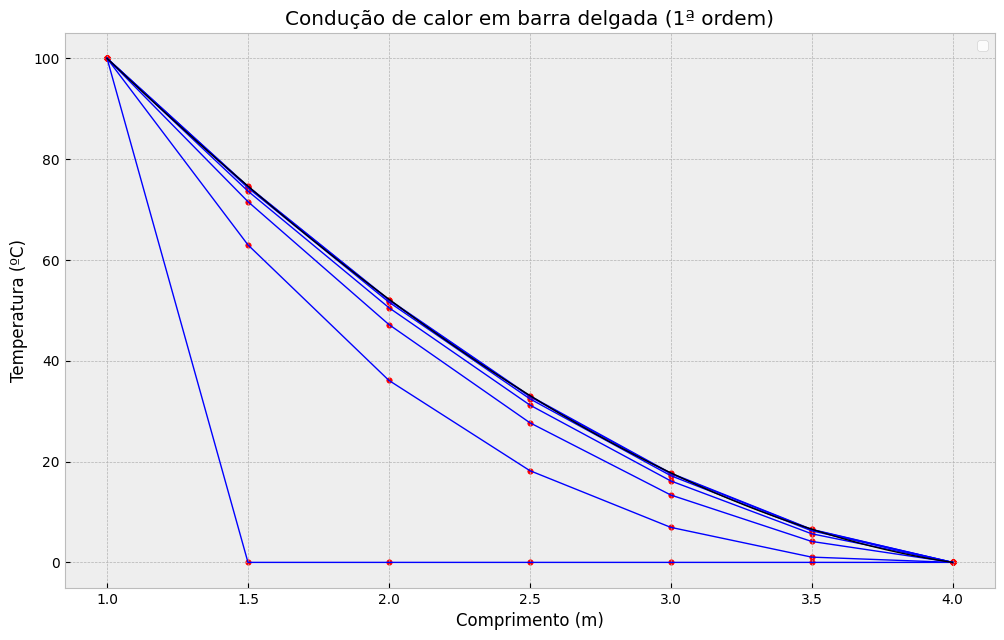

In [13]:
#Parâmetros Físicos

Xo = 1
Xf = 4
A = 1
k = 5
Tto = 0
To = 100
Tf = 0
to = 0
tf = 2
dt = 0.333
nt = int((tf-to)/dt+1)

def S(x):
    return (50/3)*(x+2)

#Parâmetros numéricos############################

#OBS.: "ligacoes" se difere de nós pois se refere a pontos que ficam apenas nas fronteiras de cada elemento. "ligacoes" não abrange nós no interior de elementos, como nos de 2ª ordem.

ordemElemento = 1   #1 ou 2

ligacoes = 7                              
malha = np.linspace(Xo,Xf,ligacoes)

#################################################

##Produtos das funções de forma 1ª ordem
if ordemElemento == 1:

    ###Definindo nº de elementos e nós 
    nElementos = len(malha)-1
    nNos = nElementos+1
    
    nNosLocais = 2

    K11 = lambda x,X1,X2 : B11(x,X1,X2)*k*B11(x,X1,X2)
    K12 = lambda x,X1,X2 : B11(x,X1,X2)*k*B12(x,X1,X2)
    K21 = lambda x,X1,X2 : B12(x,X1,X2)*k*B11(x,X1,X2)
    K22 = lambda x,X1,X2 : B12(x,X1,X2)*k*B12(x,X1,X2)

    G1 = lambda x,X1,X2 : S(x)*N11(x,X1,X2)
    G2 = lambda x,X1,X2 : S(x)*N12(x,X1,X2)

    M11 = lambda x,X1,X2 : N11(x,X1,X2)*N11(x,X1,X2)
    M12 = lambda x,X1,X2 : N11(x,X1,X2)*N12(x,X1,X2)
    M21 = lambda x,X1,X2 : N12(x,X1,X2)*N11(x,X1,X2)
    M22 = lambda x,X1,X2 : N12(x,X1,X2)*N12(x,X1,X2)

    ###Função de integração a ser usada
    def INTEGRACAO_1(f,X1,X2):
        return sp.integrate.quad(f,X1,X2,(X1,X2))[0]

##Integrando e montando
    listaKe = np.empty((2,2,nElementos))
    listaGe = np.empty((1,2,nElementos))
    listaMe = np.empty((2,2,nElementos))

    for e in range(0,nElementos):
        Ke = np.array([[INTEGRACAO_1(K11,malha[e],malha[e+1]),INTEGRACAO_1(K12,malha[e],malha[e+1])],
                    [INTEGRACAO_1(K21,malha[e],malha[e+1]),INTEGRACAO_1(K22,malha[e],malha[e+1])]])    

        Ge = np.array([[INTEGRACAO_1(G1,malha[e],malha[e+1]),INTEGRACAO_1(G2,malha[e],malha[e+1])]])

        Me = np.array([[INTEGRACAO_1(M11,malha[e],malha[e+1]),INTEGRACAO_1(M12,malha[e],malha[e+1])],
                    [INTEGRACAO_1(M21,malha[e],malha[e+1]),INTEGRACAO_1(M22,malha[e],malha[e+1])]]) 

        listaKe[:,:,e] = Ke
        listaGe[:,:,e] = Ge
        listaMe[:,:,e] = Me


##Produtos das funções de forma 2ª ordem
elif ordemElemento == 2:
    
    ###Definindo nº de elementos e nós
    nElementos = int(len(malha)-1)
    nNos = nElementos + 1 + nElementos
    nNosLocais = 3

    ###MalhaPLT (Malha para plotagem (com os pontos intermediários de cada elemento))
    malhaPlot_e0 = np.array([malha[0],(malha[0]+malha[1])/2,malha[1]])   #1º elemento
    
    malhaPlot = np.empty(nNos-3)  #demais elementos

    for i in range(1,nElementos):

        nosElemento = np.array([(malha[i]+malha[i+1])/2, malha[i+1]])  
        malhaPlot[2*(i-1):2*(i)] = nosElemento

    malhaPLT = np.concatenate((malhaPlot_e0,malhaPlot))

    K11 = lambda x,X1,X2,X3 : B21(x,X1,X2,X3)*k*B21(x,X1,X2,X3)
    K12 = lambda x,X1,X2,X3 : B21(x,X1,X2,X3)*k*B22(x,X1,X2,X3)
    K13 = lambda x,X1,X2,X3 : B21(x,X1,X2,X3)*k*B23(x,X1,X2,X3)
    K21 = lambda x,X1,X2,X3 : B22(x,X1,X2,X3)*k*B21(x,X1,X2,X3)
    K22 = lambda x,X1,X2,X3 : B22(x,X1,X2,X3)*k*B22(x,X1,X2,X3)
    K23 = lambda x,X1,X2,X3 : B22(x,X1,X2,X3)*k*B23(x,X1,X2,X3)
    K31 = lambda x,X1,X2,X3 : B23(x,X1,X2,X3)*k*B21(x,X1,X2,X3)
    K32 = lambda x,X1,X2,X3 : B23(x,X1,X2,X3)*k*B22(x,X1,X2,X3)
    K33 = lambda x,X1,X2,X3 : B23(x,X1,X2,X3)*k*B23(x,X1,X2,X3)

    G1 = lambda x,X1,X2,X3 : S(x)*N21(x,X1,X2,X3)
    G2 = lambda x,X1,X2,X3 : S(x)*N22(x,X1,X2,X3)
    G3 = lambda x,X1,X2,X3 : S(x)*N23(x,X1,X2,X3)

    M11 = lambda x,X1,X2,X3 : N21(x,X1,X2,X3)*N21(x,X1,X2,X3)
    M12 = lambda x,X1,X2,X3 : N21(x,X1,X2,X3)*N22(x,X1,X2,X3)
    M13 = lambda x,X1,X2,X3 : N21(x,X1,X2,X3)*N23(x,X1,X2,X3)
    M21 = lambda x,X1,X2,X3 : N22(x,X1,X2,X3)*N21(x,X1,X2,X3)
    M22 = lambda x,X1,X2,X3 : N22(x,X1,X2,X3)*N22(x,X1,X2,X3)
    M23 = lambda x,X1,X2,X3 : N22(x,X1,X2,X3)*N23(x,X1,X2,X3)
    M31 = lambda x,X1,X2,X3 : N23(x,X1,X2,X3)*N21(x,X1,X2,X3)
    M32 = lambda x,X1,X2,X3 : N23(x,X1,X2,X3)*N22(x,X1,X2,X3)
    M33 = lambda x,X1,X2,X3 : N23(x,X1,X2,X3)*N23(x,X1,X2,X3)

    ###Função de integração a ser usada
    def INTEGRACAO_2(f,X1,X2,X3):
        return sp.integrate.quad(f,X1,X3,(X1,X2,X3))[0]

##Integrando e montando
    listaKe = np.empty((3,3,nElementos))
    listaGe = np.empty((1,3,nElementos))
    listaMe = np.empty((3,3,nElementos))

    '''Há um if dentro do loop porque elementos de 2ª ordem podem terminar incompletos dependendo de como discretizarmos o domínio. Dessa forma é 
    necessário definir uma integração particular para o último elemento em que o integramos só até a metade'''
    
    indice_elemento = 0
    for e in range(0,nElementos):

        no_medio = (malha[e]+malha[e+1])/2
        Ke = np.array([[INTEGRACAO_2(K11,malha[e],no_medio,malha[e+1]),INTEGRACAO_2(K12,malha[e],no_medio,malha[e+1]),INTEGRACAO_2(K13,malha[e],no_medio,malha[e+1])],
                    [INTEGRACAO_2(K21,malha[e],no_medio,malha[e+1]),INTEGRACAO_2(K22,malha[e],no_medio,malha[e+1]),INTEGRACAO_2(K23,malha[e],no_medio,malha[e+1])],
                    [INTEGRACAO_2(K31,malha[e],no_medio,malha[e+1]),INTEGRACAO_2(K32,malha[e],no_medio,malha[e+1]),INTEGRACAO_2(K33,malha[e],no_medio,malha[e+1])]])
            
        Ge = np.array([[INTEGRACAO_2(G1,malha[e],no_medio,malha[e+1]),INTEGRACAO_2(G2,malha[e],no_medio,malha[e+1]),INTEGRACAO_2(G3,malha[e],no_medio,malha[e+1])]])
        
        Me = np.array([[INTEGRACAO_2(M11,malha[e],no_medio,malha[e+1]),INTEGRACAO_2(M12,malha[e],no_medio,malha[e+1]),INTEGRACAO_2(M13,malha[e],no_medio,malha[e+1])],
                    [INTEGRACAO_2(M21,malha[e],no_medio,malha[e+1]),INTEGRACAO_2(M22,malha[e],no_medio,malha[e+1]),INTEGRACAO_2(M23,malha[e],no_medio,malha[e+1])],
                    [INTEGRACAO_2(M31,malha[e],no_medio,malha[e+1]),INTEGRACAO_2(M32,malha[e],no_medio,malha[e+1]),INTEGRACAO_2(M33,malha[e],no_medio,malha[e+1])]])

        listaKe[:,:,indice_elemento] = Ke
        listaGe[:,:,indice_elemento] = Ge
        listaMe[:,:,indice_elemento] = Me
        indice_elemento = indice_elemento + 1

# Matriz de conectividade (IEN)

IEN = np.zeros((nElementos,nNosLocais))

## 1ª ORDEM
if ordemElemento == 1:
        
    for elemento in range(nElementos):
        for noLocal in range(nNosLocais):
                
            IEN[elemento,noLocal] = elemento*(nNosLocais - 1) + noLocal

## 2ª ORDEM
elif ordemElemento == 2:
    for elemento in range(nElementos):

        for noLocal in range(nNosLocais):

            IEN[elemento,noLocal] = elemento*(nNosLocais - 1) + noLocal

print("Matriz de conectividade: ")
print(IEN)

# Matrizes globais

Ks = np.zeros((nNos,nNos))    #Ks pois se refere a matriz global ainda em seu estado singular
Gs = np.zeros(nNos)
Ms = np.zeros((nNos,nNos))
nMatrizesElementares = len(listaKe[0,0,:])

## 1ª ORDEM
if ordemElemento == 1:

    ###Adicionando cada matriz elementar à matriz global
    for K_elementar_index in range(nMatrizesElementares):

        Kaux = np.zeros((nNos,nNos))

        ##Permutação da matriz global
        posicoes = list(it.product(IEN[K_elementar_index], repeat=2))   #Retorna tuplas de permutações da lista. O parâmetro r define quantos elementos da lista permutar por vez
        posicoes = [(int(x), int(y)) for x,y in posicoes]             #O método retorna tuplas de floats, apenas passei os dados para int
                
        ##Permutação da matriz elementar
        posicoes_locais = list(it.product([0,1], repeat=2))   #Retorna tuplas de permutações da lista. O parâmetro r define quantos elementos da lista permutar por vez
        posicoes_locais = [(int(x), int(y)) for x,y in posicoes_locais]
                
        #print(posicoes)
        #print(posicoes_locais)
        for i in range(len(posicoes)):
            posicao_global = posicoes[i] 
            posicao_local = posicoes_locais[i] + (K_elementar_index,)
            Kaux[posicao_global] = listaKe[posicao_local]
        #print(Kaux)
        Ks = Ks + Kaux
        
    ###Adicionando cada matriz elementar Ge à matriz global G
    for G_elementar_index in range(nMatrizesElementares):
        
        Gaux = np.zeros(nNos)

        for i in range(2):
            Gaux[G_elementar_index*(nNosLocais - 1) + i] = listaGe[:,i,G_elementar_index]
        #print(Gaux)
        Gs = Gs + Gaux

    for M_elementar_index in range(nMatrizesElementares):

        Maux = np.zeros((nNos,nNos))

        ##Permutação da matriz global
        posicoes = list(it.product(IEN[M_elementar_index], repeat=2))   #Retorna tuplas de permutações da lista. O parâmetro r define quantos elementos da lista permutar por vez
        posicoes = [(int(x), int(y)) for x,y in posicoes]             #O método retorna tuplas de floats, apenas passei os dados para int
                
        ##Permutação da matriz elementar
        posicoes_locais = list(it.product([0,1], repeat=2))   #Retorna tuplas de permutações da lista. O parâmetro r define quantos elementos da lista permutar por vez
        posicoes_locais = [(int(x), int(y)) for x,y in posicoes_locais]
                
        #print(posicoes)
        #print(posicoes_locais)
        for i in range(len(posicoes)):
            posicao_global = posicoes[i] 
            posicao_local = posicoes_locais[i] + (M_elementar_index,)
            Maux[posicao_global] = listaMe[posicao_local]
        #print(Maux)
        Ms = Ms + Maux
        
    #print("\nMatrizes globais singulares: ")
    #print("Ks")  
    #print(np.array_str(Ks, precision=2, suppress_small=True))
    #print("Gs")
    #print(np.array_str(Gs, precision=2, suppress_small=True))
    
## 2ª ORDEM
elif ordemElemento == 2:

    ###Adicionando cada matriz elementar Ke à matriz global K
    for K_elementar_index in range(nMatrizesElementares):
        
        Kaux = np.zeros((nNos,nNos))

        ##Permutação da matriz global
        posicoes = list(it.product(IEN[K_elementar_index], repeat=2))   #Retorna tuplas de permutações da lista. O parâmetro r define quantos elementos da lista permutar por vez
        posicoes = [(int(x), int(y)) for x,y in posicoes]             #O método retorna tuplas de floats, apenas passei os dados para int
        
        ##Permutação da matriz elementar
        posicoes_locais = list(it.product([0,1,2], repeat=2))   #Retorna tuplas de permutações da lista. O parâmetro r define quantos elementos da lista permutar por vez
        posicoes_locais = [(int(x), int(y)) for x,y in posicoes_locais]
        
        #print(posicoes)
        #print(posicoes_locais)
        for i in range(len(posicoes)):
            posicao_global = posicoes[i]
            posicao_local = posicoes_locais[i] + (K_elementar_index,)
            Kaux[posicao_global] = listaKe[posicao_local]
        #print(Kaux)
        Ks = Ks + Kaux
        
    ###Adicionando cada matriz elementar Ge à matriz global G
    for G_elementar_index in range(nMatrizesElementares):
        
        Gaux = np.zeros(nNos)

        for i in range(3):
            Gaux[G_elementar_index*(nNosLocais - 1) + i] = listaGe[:,i,G_elementar_index]

        Gs = Gs + Gaux
    
    for M_elementar_index in range(nMatrizesElementares):
        
        Maux = np.zeros((nNos,nNos))

        ##Permutação da matriz global
        posicoes = list(it.product(IEN[M_elementar_index], repeat=2))   #Retorna tuplas de permutações da lista. O parâmetro r define quantos elementos da lista permutar por vez
        posicoes = [(int(x), int(y)) for x,y in posicoes]             #O método retorna tuplas de floats, apenas passei os dados para int
        
        ##Permutação da matriz elementar
        posicoes_locais = list(it.product([0,1,2], repeat=2))   #Retorna tuplas de permutações da lista. O parâmetro r define quantos elementos da lista permutar por vez
        posicoes_locais = [(int(x), int(y)) for x,y in posicoes_locais]
        
        #print(posicoes)
        #print(posicoes_locais)
        for i in range(len(posicoes)):
            posicao_global = posicoes[i]
            posicao_local = posicoes_locais[i] + (M_elementar_index,)
            Maux[posicao_global] = listaMe[posicao_local]
        #print(Maux)
        Ms = Ms + Maux

    #print("\nMatrizes globais singulares: ")
    #print("Ks")  
    #print(np.array_str(Ks, precision=2, suppress_small=True))
    #print("Gs")
    #print(np.array_str(Gs, precision=2, suppress_small=True))
    
# Aplicação das condições de contorno na matriz e vetor independente:   K.T + G = 0

##K
###1º contorno
K = np.delete(Ks,obj=0,axis=0)   #eliminando linha
K = np.delete(K,obj=0, axis=1)   #eliminando coluna

M = np.delete(Ms,obj=0,axis=0)   #eliminando linha
M = np.delete(M,obj=0, axis=1)   #eliminando coluna
###2º contorno
K = np.delete(K,obj=-1, axis=0)    #eliminando linha
K = np.delete(K,obj=-1, axis=1)   #eliminando coluna

M = np.delete(M,obj=-1, axis=0)    #eliminando linha
M = np.delete(M,obj=-1, axis=1)   #eliminando coluna

##G
G = Gs[1:-1]
KLinhaEliminada = np.delete(Ks,obj=0,axis=0)
KLinhaEliminada = np.delete(KLinhaEliminada,obj=-1,axis=0)

for i in range(len(G)):

    G[i] = G[i] + To*KLinhaEliminada[i,0] + Tf*KLinhaEliminada[i,-1]

print("\nMatrizes globais: ")
print("K")  
print(np.array_str(K, precision=2, suppress_small=True))
print("\nG")
print(np.array_str(G, precision=2, suppress_small=True))
print("\nM")
print(np.array_str(M, precision=2, suppress_small=True))

# Solucionando o sistema##########################

campos = np.empty((nNos,nt))

## Condição inicial
campo0 = Tto*np.ones(nNos-2)
BCo = np.array([To])
BCf = np.array([Tf])
campo0 = np.concatenate((BCo,campo0,BCf))

campos[:,0] = campo0

## Demais instantes 
A = M/dt + K    # Formatando na forma A.T = b

for n in range(1,nt):

    b = M/dt@campos[1:-1,n-1] - G     # Formatando na forma A.T = b
    
    CampoTSemContorno = np.linalg.solve(A,b)

    BCo = np.array([To])
    BCf = np.array([Tf])
    campo = np.concatenate((BCo,CampoTSemContorno,BCf))
    print(campo)
    campos[:,n] = campo

# Gerando o campo de temperatura##################

def CampoTNumerico(malha,T):
    
    if ordemElemento == 1:
        np_e = 10   # nº de pontos que a interpolação calculará no interior de cada elemento

        # Separamos o 1º elemento do restante do loop pq cada elemento compartilha seu nó inicial com o fim do elemento anterior
        # Por isso inserimos um 1º elemento por completo e depois vamos completando os nós dos demais

        ## 1º elemento
        Dom_interpol_e0 = np.linspace(malha[0],malha[1],np_e)
        interpol_e0 = np.array(N11(Dom_interpol_e0,malha[0],malha[0+1])*T[0] + N12(Dom_interpol_e0,malha[0],malha[0+1])*T[0+1])
        
        ## demais elementos
        Dom_interpol = np.empty((nElementos-1)*(np_e-1))
        interpol = np.empty((nElementos-1)*(np_e-1))
        
        for i in range(1, nElementos):

            Dom_interpol_e = np.linspace(malha[i], malha[i+1], np_e)
            npDom = len(Dom_interpol_e)
            
            S = N11(Dom_interpol_e,malha[i],malha[i+1])*T[i] + N12(Dom_interpol_e,malha[i],malha[i+1])*T[i+1]
             
            Dom_interpol[(npDom-1)*(i-1) : (npDom-1)*(i)] = Dom_interpol_e[1:]
            interpol[(npDom-1)*(i-1) : (npDom-1)*(i)] = S[1:]
        
        Dom_interpol = np.concatenate((Dom_interpol_e0, Dom_interpol))
        Campo_T = np.concatenate((interpol_e0, interpol))

        return Dom_interpol, Campo_T
    
    elif ordemElemento == 2:
        np_e = 10   # nº de pontos que a interpolação calculará no interior de cada elemento

        # Separamos o 1º elemento do restante do loop pq cada elemento compartilha seu nó inicial com o fim do elemento anterior
        # Por isso inserimos um 1º elemento por completo e depois vamos completando os nós dos demais

        ## 1º elemento
        no_medio_e0 = (malha[0]+malha[1])/2
        Dom_interpol_e0 = np.linspace(malha[0],malha[1],np_e)
        interpol_e0 = np.array(N21(Dom_interpol_e0,malha[0],no_medio_e0,malha[1])*T[0] 
                             + N22(Dom_interpol_e0,malha[0],no_medio_e0,malha[1])*T[0+1] 
                             + N23(Dom_interpol_e0,malha[0],no_medio_e0,malha[1])*T[0+2])
        
        ## demais elementos
        Dom_interpol = np.empty((nElementos-1)*(np_e-1))
        interpol = np.empty((nElementos-1)*(np_e-1))

        for i in range(1,nElementos):

            no_medio = (malha[i]+malha[i+1])/2
            
            Dom_interpol_e = np.linspace(malha[i],malha[i+1],np_e)
            npDom = len(Dom_interpol_e)
            
            S = np.array(N21(Dom_interpol_e,malha[i],no_medio,malha[i+1])*T[2*i] 
                       + N22(Dom_interpol_e,malha[i],no_medio,malha[i+1])*T[2*i+1] 
                       + N23(Dom_interpol_e,malha[i],no_medio,malha[i+1])*T[2*i+2])

            Dom_interpol[(npDom-1)*(i-1) : (npDom-1)*i] = Dom_interpol_e[1:]
            interpol[(npDom-1)*(i-1) : (npDom-1)*i] = S[1:]

        Dom_interpol = np.concatenate((Dom_interpol_e0, Dom_interpol))
        Campo_T = np.concatenate((interpol_e0, interpol))

        return Dom_interpol, Campo_T

#Solução analítica estacionária

Dom_analitica = np.linspace(Xo,Xf,500)

def CampoTAnalitico(x):
    return (5/9)*x**3 + (10/3)*x**2 - (185/3)*x + 1420/9

#Exibindo as soluções

plt.style.use('bmh')

fig, (ax1) = plt.subplots(1, 1, sharey=True, sharex = True, figsize = (12,7.2))

if ordemElemento == 1:

    for n in range(0,nt):

        ax1.scatter(malha, campos[:,n], s=15, color='red')
        ax1.plot(CampoTNumerico(malha,campos[:,n])[0], CampoTNumerico(malha,campos[:,n])[1], color='blue', linewidth=1.0)
    
    ax1.plot(Dom_analitica, CampoTAnalitico(Dom_analitica), color='black', linewidth=1.0)

    ax1.set_title('Condução de calor em barra delgada (1ª ordem)')
    ax1.set_xlabel('Comprimento (m)')
    ax1.set_ylabel('Temperatura (ºC)')
    ax1.legend(loc='best',facecolor ='w')


elif ordemElemento == 2:

    for n in range(0,nt):

        ax1.scatter(malhaPLT, campos[:,n], s=15, color='red')
        ax1.plot(CampoTNumerico(malha,campos[:,n])[0], CampoTNumerico(malha,campos[:,n])[1], color='blue', linewidth=1.0)
    
    ax1.plot(Dom_analitica, CampoTAnalitico(Dom_analitica), color='black', linewidth=1.0)
    
    ax1.set_title('Condução de calor em barra delgada (2ª ordem)')
    ax1.set_xlabel('Comprimento (m)')
    ax1.set_ylabel('Temperatura (ºC)')
    ax1.legend(loc='best',facecolor ='w')

## Condução de calor bidimensional

## Rascunho

In [ ]:

        '''
        n = int(math.ceil(len(x)/nElementos))
        x_sliced = np.empty((nElementos,n))

        for i in range(nElementos):

            x_sliced[i] = x[(n-1)*i:(n-1)*i+n]
        
        print(malha)
        print(x_sliced)
        Campo_T_Elemento0 = np.empty(n)

        S0 = np.array(N11(x_sliced[0,:],malha[0],malha[0+1])*T[0] + N12(x_sliced[0,:],malha[0],malha[0+1])*T[0+1])
        Campo_T_Elemento0[0:n] = S0

        Campo_T = np.empty(len(x)-n)

        S = np.empty(len(x_sliced[0,1:]))

        for e in range(1,nElementos):

            S = N11(x_sliced[e,1:],malha[e],malha[e+1])*T[e] + N12(x_sliced[e,1:],malha[e],malha[e+1])*T[e+1]
            
            Campo_T[(n-1)*(e-1):(n-1)*((e-1)+1)] = S

        Campo_T = np.concatenate((Campo_T_Elemento0, Campo_T))
        '''
        '''
    if ordemElemento == 1:

        n = int(len(x)/nElementos)
        x_sliced = np.empty((nElementos,n))
        print(malha)
        print(x_sliced)
        for i in range(nElementos):

            x_sliced[i] = x[n*i:n*i+n]
        
        Campo_T = np.empty(n*nElementos)
        S = np.empty(n)
        
        for e in range(0,nElementos):

            S = N11(x_sliced[e],malha[e],malha[e+1])*T[e] + N12(x_sliced[e],malha[e],malha[e+1])*T[e+1]

            Campo_T[n*e:n*(e+1)] = S

        return Campo_T
        '''